In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Michaelis-Menten kinetics
def michaelis_menten(C, Vmax, Km):
    return Vmax * C / (Km + C)

def metabol_pbpk_three_comp(t, y, Qk, Qt, Kpk, Kpt, Vmax, Km, Vv, Vk, Vt, Dose):
    V, K, T = y
    metabolism_rate = michaelis_menten(K, Vmax, Km)
    dVdt = (Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T 
    dKdt = (Qk/Vk) * Kpk * V - (Qk/Vk)*K - metabolism_rate
    dTdt = (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return [dVdt, dKdt, dTdt]

params = {
    "Qk": 1.0, "Qt": 0.5,
    "Kpk": 0.8, "Kpt": 0.5,
    "Vmax": 0.1, "Km": 0.1,
    "Vv": 1.0, "Vk": 0.5, "Vt": 0.3,
    "Dose": 1.0
}
y0 = [0, 0, 0]
t_span = [0, 24] 
t_eval = np.linspace(t_span[0], t_span[1], 100)

In [4]:
sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)

In [72]:
len(sol.t)

100

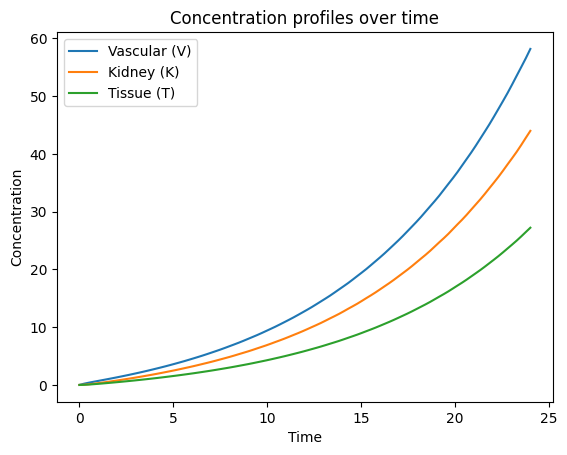

In [5]:
plt.plot(sol.t, sol.y[0], label='Vascular (V)')
plt.plot(sol.t, sol.y[1], label='Kidney (K)')
plt.plot(sol.t, sol.y[2], label='Tissue (T)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.title('Concentration profiles over time')
plt.show()

In [3]:
def generate_more_data(base_params, num_datasets, param_variation_range, initial_conditions_variation_range, noise_std):
    datasets = []
    for _ in range(num_datasets):
        varied_params = {key: np.random.uniform(low=value - param_variation_range[key], high=value + param_variation_range[key]) 
                         for key, value in base_params.items()}
        varied_initial_conditions = initial_conditions_variation_range * np.random.randn(3) + y0
        sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **varied_params), t_span, varied_initial_conditions, t_eval=t_eval)
        noisy_data = sol.y + noise_std * np.random.randn(*sol.y.shape)
        datasets.append((noisy_data, sol.t))
    return datasets


param_variation_range = {key: 0.1 * value for key, value in params.items()}
initial_conditions_variation_range = np.array([0.1, 0.1, 0.1])
noise_std = 0.01 
more_data = generate_more_data(params, 50, param_variation_range, initial_conditions_variation_range, noise_std)


In [4]:
def generate_synthetic_data(params, y0, t_span, num_samples, noise_std=0.05):
    t_eval = np.linspace(t_span[0], t_span[1], num_samples)
    sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)
    noise = noise_std * np.random.randn(*sol.y.shape)
    y_noisy = sol.y + noise
    return t_eval, y_noisy


def create_train_test_data(params, y0, t_span, num_samples=100, test_size=0.2, noise_std=0.05, random_state=42):
    t_eval, y_noisy = generate_synthetic_data(params, y0, t_span, num_samples, noise_std)
    t_tensor = torch.tensor(t_eval, dtype=torch.float32).reshape(-1, 1)
    y_tensor = torch.tensor(y_noisy.T, dtype=torch.float32) 
    t_train, t_test, y_train, y_test = train_test_split(t_tensor, y_tensor, test_size=test_size, random_state=random_state)
    return t_train, t_test, y_train, y_test

t_train, t_test, y_train, y_test = create_train_test_data(params, y0, t_span)

In [5]:
t_train.shape

torch.Size([80, 1])

In [6]:
t_test.shape

torch.Size([20, 1])

In [11]:
class torchNN(nn.Module):
    def __init__(self):
        super(torchNN, self).__init__()
        self.linear1 = nn.Linear(1, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [11]:
def physics_loss(model, inputs, params):
    Qk, Qt, Kpk, Kpt, Vmax, Km, Vv, Vk, Vt, Dose = params.values()
    inputs_with_grad = inputs.clone().requires_grad_(True)
    predictions = model(inputs)
    predictions.requires_grad_(True)
    V, K, T = predictions.unbind(1)
    V_grad, K_grad, T_grad = [
    torch.autograd.grad(out.sum(), inputs_with_grad, create_graph=True, allow_unused=True)[0]
    for out in [V, K, T]
    ]
    V_grad = V_grad if V_grad is not None else torch.zeros_like(V)
    K_grad = K_grad if K_grad is not None else torch.zeros_like(K)
    T_grad = T_grad if T_grad is not None else torch.zeros_like(T)
    dVdt_resid = V_grad - ((Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T)
    dKdt_resid = K_grad - ((Qk/Vk) * Kpk * V - (Qk/Vk)*K - Vmax * K / (Km + K))
    dTdt_resid = T_grad - ((Qt/Vt) * Kpt * V - (Qt/Vt)*T)
    total_resid = dVdt_resid.pow(2).mean() + dKdt_resid.pow(2).mean() + dTdt_resid.pow(2).mean()
    return total_resid

In [12]:
params = {
    "Qk": 1.0, "Qt": 0.5,
    "Kpk": 0.8, "Kpt": 0.5,
    "Vmax": 0.1, "Km": 0.1,
    "Vv": 1.0, "Vk": 0.5, "Vt": 0.3,
    "Dose": 1.0
}

In [9]:
def train(model, inputs, targets, params, epochs=1000, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(inputs)
        loss_data = criterion(predictions, targets)
        loss_physics = physics_loss(model, inputs, params)
        loss = loss_data # + .2*loss_physics
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [13]:
model = torchNN()
train(model, t_train, y_train, params,epochs=10000)


Epoch 0, Loss: 279.3899230957031
Epoch 100, Loss: 214.50485229492188
Epoch 200, Loss: 163.22459411621094
Epoch 300, Loss: 123.78289031982422
Epoch 400, Loss: 94.37492370605469
Epoch 500, Loss: 73.19992065429688
Epoch 600, Loss: 58.376747131347656
Epoch 700, Loss: 48.24249267578125
Epoch 800, Loss: 41.46538543701172
Epoch 900, Loss: 37.03628158569336
Epoch 1000, Loss: 34.19132995605469
Epoch 1100, Loss: 32.32189178466797
Epoch 1200, Loss: 30.86134147644043
Epoch 1300, Loss: 30.097810745239258
Epoch 1400, Loss: 29.41285514831543
Epoch 1500, Loss: 28.821287155151367
Epoch 1600, Loss: 27.90754508972168
Epoch 1700, Loss: 27.060590744018555
Epoch 1800, Loss: 26.591096878051758
Epoch 1900, Loss: 26.035261154174805
Epoch 2000, Loss: 25.61951446533203
Epoch 2100, Loss: 25.181251525878906
Epoch 2200, Loss: 24.576993942260742
Epoch 2300, Loss: 23.56553840637207
Epoch 2400, Loss: 22.799577713012695
Epoch 2500, Loss: 22.37297248840332
Epoch 2600, Loss: 21.988073348999023
Epoch 2700, Loss: 21.627197

In [15]:
model.eval()
with torch.no_grad():
    predictions_train = model(t_train)
    predictions_test = model(t_test)

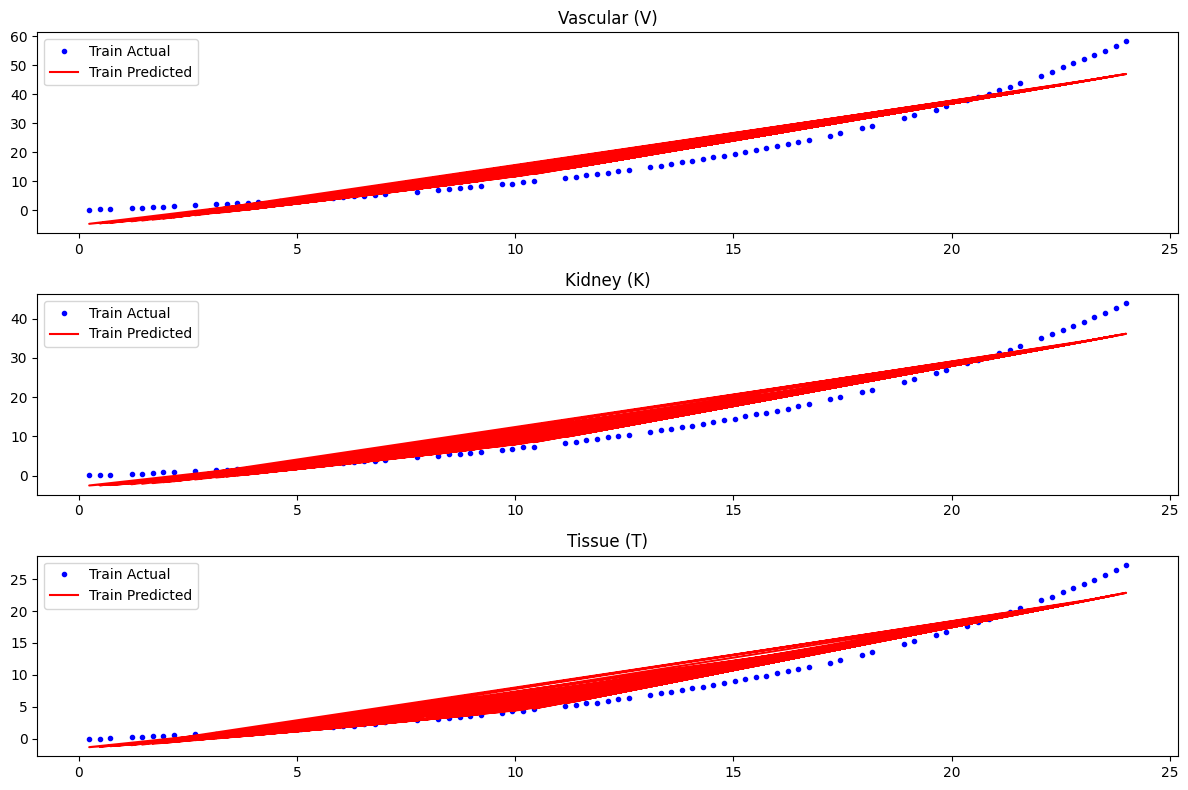

In [16]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['Vascular (V)', 'Kidney (K)', 'Tissue (T)']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train.numpy(), y_train[:, i].numpy(), 'b.', label='Train Actual')
    plt.plot(t_train.numpy(), predictions_train[:, i].numpy(), 'r-', label='Train Predicted')
    plt.title(label)
    plt.legend()

plt.tight_layout()
plt.show()

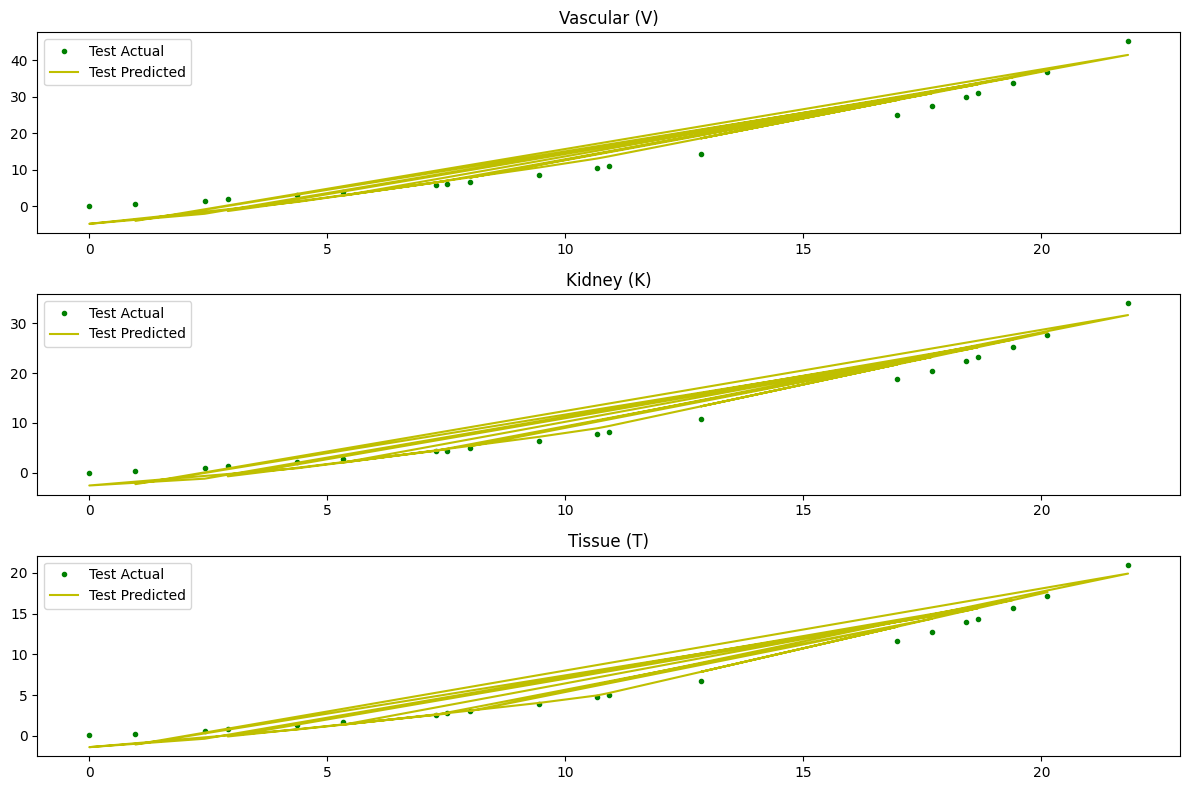

In [17]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['Vascular (V)', 'Kidney (K)', 'Tissue (T)']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_test.numpy(), y_test[:, i].numpy(), 'g.', label='Test Actual')
    plt.plot(t_test.numpy(), predictions_test[:, i].numpy(), 'y-', label='Test Predicted')
    plt.title(label)
    plt.legend()

plt.tight_layout()
plt.show()

In [18]:
def train(model, inputs, targets, params, epochs=1000, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(inputs)
        loss_data = criterion(predictions, targets)
        loss_physics = physics_loss(model, inputs, params)
        loss = loss_data + .2*loss_physics
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [20]:
pinn_model = torchNN()
train(pinn_model, t_train, y_train, params,epochs=10000)

Epoch 0, Loss: 231.06170654296875
Epoch 100, Loss: 180.40464782714844
Epoch 200, Loss: 140.50453186035156
Epoch 300, Loss: 109.05425262451172
Epoch 400, Loss: 84.56482696533203
Epoch 500, Loss: 66.2372817993164
Epoch 600, Loss: 53.22494125366211
Epoch 700, Loss: 44.49119186401367
Epoch 800, Loss: 38.967376708984375
Epoch 900, Loss: 35.65226364135742
Epoch 1000, Loss: 33.59014129638672
Epoch 1100, Loss: 32.4611701965332
Epoch 1200, Loss: 31.821136474609375
Epoch 1300, Loss: 31.354026794433594
Epoch 1400, Loss: 30.835668563842773
Epoch 1500, Loss: 29.86557388305664
Epoch 1600, Loss: 28.761707305908203
Epoch 1700, Loss: 28.042570114135742
Epoch 1800, Loss: 27.6060733795166
Epoch 1900, Loss: 27.208066940307617
Epoch 2000, Loss: 26.810283660888672
Epoch 2100, Loss: 26.3804874420166
Epoch 2200, Loss: 25.802690505981445
Epoch 2300, Loss: 25.39259910583496
Epoch 2400, Loss: 25.021242141723633
Epoch 2500, Loss: 24.66460609436035
Epoch 2600, Loss: 24.316280364990234
Epoch 2700, Loss: 23.97123527

In [21]:
pinn_model.eval()
with torch.no_grad():
    predictions_train = pinn_model(t_train)
    predictions_test = pinn_model(t_test)

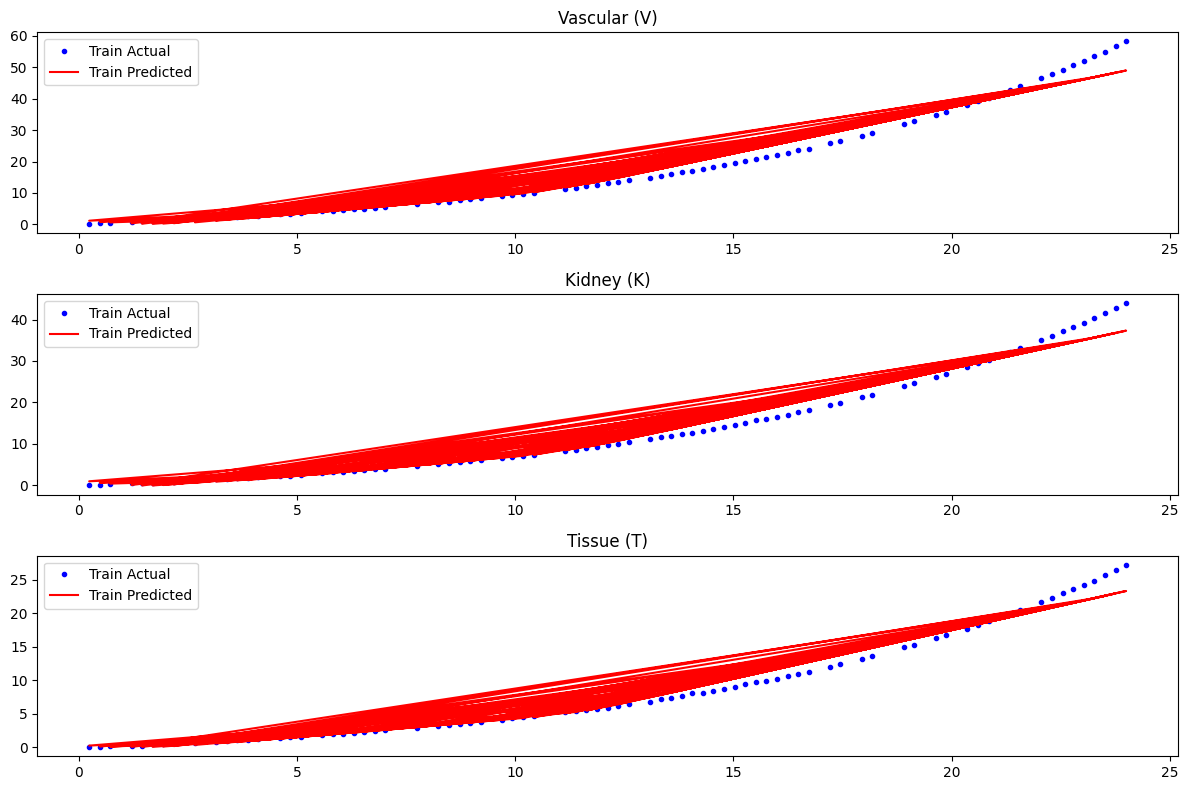

In [22]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['Vascular (V)', 'Kidney (K)', 'Tissue (T)']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train.numpy(), y_train[:, i].numpy(), 'b.', label='Train Actual')
    plt.plot(t_train.numpy(), predictions_train[:, i].numpy(), 'r-', label='Train Predicted')
    plt.title(label)
    plt.legend()

plt.tight_layout()
plt.show()

In [8]:
def physics_regularization(model, inputs, params):
    Qk, Qt, Kpk, Kpt, Vmax, Km, Vv, Vk, Vt, Dose = params.values()
    inputs_with_grad = inputs.clone().requires_grad_(True)
    predictions = model(inputs_with_grad)
    V, K, T = predictions.unbind(1)
    V.requires_grad_(True)
    K.requires_grad_(True)
    T.requires_grad_(True)
    V_grad = torch.autograd.grad(V.sum(), inputs_with_grad, create_graph=True)[0]
    K_grad = torch.autograd.grad(K.sum(), inputs_with_grad, create_graph=True)[0]
    T_grad = torch.autograd.grad(T.sum(), inputs_with_grad, create_graph=True)[0]
    dVdt_pred = V_grad
    dKdt_pred = K_grad
    dTdt_pred = T_grad
    dVdt_residual = dVdt_pred - ((Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T)
    dKdt_residual = dKdt_pred - ((Qk/Vk) * Kpk * V - (Qk/Vk)*K - michaelis_menten(K, Vmax, Km))
    dTdt_residual = dTdt_pred - ((Qt/Vt) * Kpt * V - (Qt/Vt)*T)
    regularization = torch.mean(dVdt_residual ** 2) + torch.mean(dKdt_residual ** 2) + torch.mean(dTdt_residual ** 2)
    return regularization


def loss_function(model_output, target, model, inputs, params, physics_reg_weight=0.1):
    mse_loss = nn.MSELoss()(model_output, target)
    physics_loss = physics_regularization(model, inputs, params)
    total_loss = mse_loss + physics_reg_weight * physics_loss
    return total_loss


In [9]:
def train(model, inputs, targets, params, epochs=1000, lr=0.0001, physics_reg_weight=0.2):
    optimizer = Adam(model.parameters(), lr=lr)  
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, targets, model, inputs, params, physics_reg_weight)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [12]:
regl_model = torchNN()
train(regl_model, t_train, y_train, params,epochs=10000)

Epoch 0, Loss: 388.2676696777344
Epoch 100, Loss: 329.8688049316406
Epoch 200, Loss: 277.93853759765625
Epoch 300, Loss: 268.16162109375
Epoch 400, Loss: 267.54730224609375
Epoch 500, Loss: 267.37103271484375
Epoch 600, Loss: 267.2257385253906
Epoch 700, Loss: 267.11785888671875
Epoch 800, Loss: 267.0255126953125
Epoch 900, Loss: 266.9324951171875
Epoch 1000, Loss: 266.83868408203125
Epoch 1100, Loss: 266.74432373046875
Epoch 1200, Loss: 266.6494140625
Epoch 1300, Loss: 266.5541687011719
Epoch 1400, Loss: 266.4585876464844
Epoch 1500, Loss: 266.3628234863281
Epoch 1600, Loss: 266.26690673828125
Epoch 1700, Loss: 266.1708984375
Epoch 1800, Loss: 266.07489013671875
Epoch 1900, Loss: 265.9789123535156
Epoch 2000, Loss: 265.88385009765625
Epoch 2100, Loss: 265.7882080078125
Epoch 2200, Loss: 265.6927490234375
Epoch 2300, Loss: 265.5974426269531
Epoch 2400, Loss: 265.5023193359375
Epoch 2500, Loss: 265.40740966796875
Epoch 2600, Loss: 265.3127136230469
Epoch 2700, Loss: 265.21820068359375
E

In [14]:
regl_model.eval()
with torch.no_grad():
    predictions_train = regl_model(t_train)
    predictions_test = regl_model(t_test)

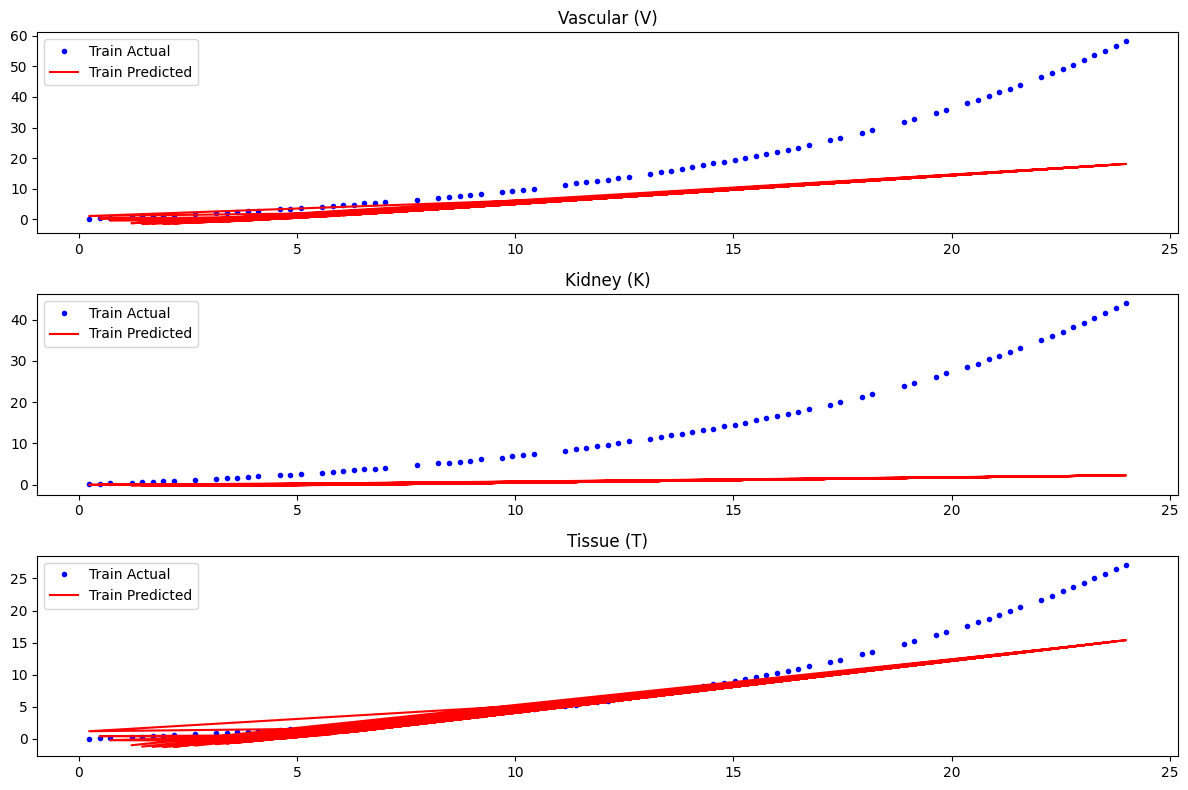

In [15]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['Vascular (V)', 'Kidney (K)', 'Tissue (T)']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train.numpy(), y_train[:, i].numpy(), 'b.', label='Train Actual')
    plt.plot(t_train.numpy(), predictions_train[:, i].numpy(), 'r-', label='Train Predicted')
    plt.title(label)
    plt.legend()

plt.tight_layout()
plt.show()

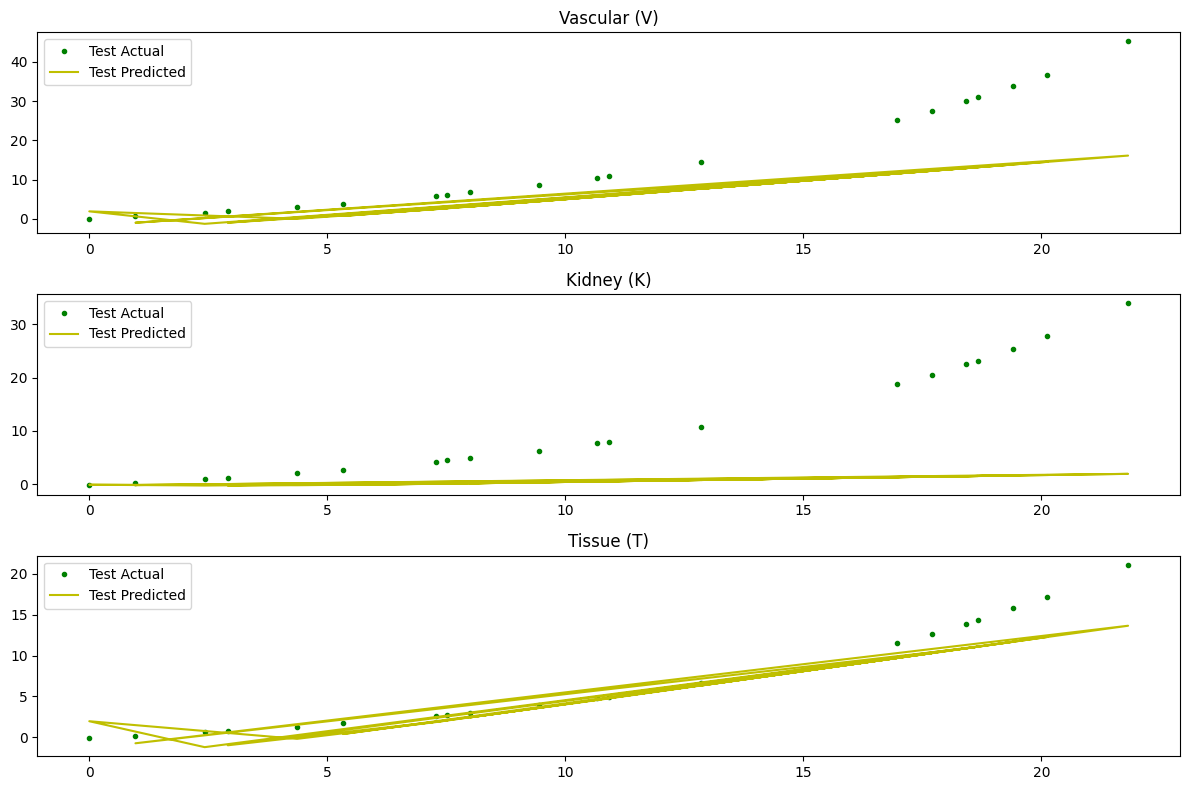

In [16]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(['Vascular (V)', 'Kidney (K)', 'Tissue (T)']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_test.numpy(), y_test[:, i].numpy(), 'g.', label='Test Actual')
    plt.plot(t_test.numpy(), predictions_test[:, i].numpy(), 'y-', label='Test Predicted')
    plt.title(label)
    plt.legend()

plt.tight_layout()
plt.show()

In [2]:
print("h")

h
